### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/AssoruleMining">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')
# Import other libraries required. All *.py will be 
# stored under the following location i.e. '/content/example.py'.
!git clone 'http://github.com/Nak007/AssoruleMining.git'
!pip install PrettyTable

## Example

In [158]:
import pandas as pd, numpy as np, sys, os
try: sys.path.append('/content/AssoruleMining')
except: pass
from AssoruleMining import *
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import matplotlib as mpl

In [30]:
X = pd.read_csv('C:\\Users\\Micky\\Desktop\\assoc_rules_data.txt', sep="|").drop(columns=["Uid","dataset"])

Out-Of-Time periods.

In [60]:
oot_periods = ['2021-11', '2021-12', '2022-01', 
               '2022-02', '2022-03', '2022-04']

In [132]:
eval_set = dict()
for mth in np.unique(X["month_id"]):
    a = X.loc[X["month_id"]==mth,:].reset_index(drop=True).copy()
    b = a.pop("f_fraud").values
    eval_set[mth] = (a.drop(columns=["month_id"]),b)

In-Time periods.

In [32]:
periods = np.unique(X["month_id"])
periods = periods[~np.isin(periods, oot_periods)]
X0 = X.loc[X["month_id"].isin(periods),:].drop(columns=["month_id"]).reset_index(drop=True)
y0 = X0.pop("f_fraud").values

Split data into **train**, and **test** sets [(**`train_test_split`**)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [33]:
X_train, X_test, y_train, y_test = tts(X0, y0, test_size=0.3, shuffle=True, random_state=0)

## Validation of rules

Eliminate rule(s) with false alarms.

In [36]:
columns = X_train.columns[(((X_train + y_train.reshape(-1,1))==2).sum(0)==0)==False]
print("Remaining rules: {:,d} / {:,d}".format(len(columns), X_train.shape[1]))

Remaining rules: 106 / 155


<font color=blue size=4>**$1^{st}$ set of rules** </font>

In [37]:
X1 = X_train.loc[:,columns].copy()
y1 = y_train.copy()
rules1 = dict([(c,(c,"==",1)) for n,c in enumerate(X1.columns)])

In [38]:
asso1 = AssoRuleMining(metric="f1", operator="or", n_batches=5, n_jobs=4, max_features=10)
asso1.fit(X1, y1, rules=rules1)

**info** (attribute) : a summary table that comes in a form of `dict` with keys as column headers. It can be imported into a pandas DataFrame.

In [39]:
pd.DataFrame(asso1.info).sort_values(by=["recall","n_features"], 
                                     ascending=[False,True]).head(5)

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
14,None,VRM001CA,7,0.809333,0.430942,0.436516,0.809333,0.298851,0.550080
10,None,ECOM055.1,7,0.717037,0.316226,0.480066,0.717037,0.360820,0.537805
3,None,ECOM010.R,6,0.696093,0.213444,0.594612,0.696093,0.518956,0.475386
1,None,ECOM005,7,0.553753,0.155361,0.560386,0.553753,0.567181,0.505011
11,None,ECOM067.1,6,0.523348,0.132885,0.570381,0.523348,0.626701,0.497767


For this example, we focus on `recall`. Hence, we choose rule(s) that has the highest `recall` accordingly. In the case of a tie, we select `variable`, whose number of features is the lowest. This is for the sake of reducing rule complexity.

We use **`RuleToFeature`** to convert rules into features array.

In [40]:
rule1_index = "VRM001CA"
FirstRule = RuleToFeature(X_train, asso1.asso_results_, which_rules=[rule1_index])

Use **`print_rule`** to tabulate rule information.

In [41]:
print_rule(FirstRule[1][rule1_index])

Operator:  or
+------+------------------------+------+-------+
| Item | Varibale               | Sign | Value |
+------+------------------------+------+-------+
|  1   | VRM001CA               |  ==  |  1.00 |
|  2   | ECOM017.1R             |  ==  |  1.00 |
|  3   | ECOM010.R              |  ==  |  1.00 |
|  4   | ECOM016.1              |  ==  |  1.00 |
|  5   | ECOM014.2              |  ==  |  1.00 |
|  6   | EDC0098.1              |  ==  |  1.00 |
|  7   | PGW0012.4_POS01_Reject |  ==  |  1.00 |
+------+------------------------+------+-------+


<font color=blue size=4>**$2^{nd}$ set of rules** </font>

Before determining next set of rules, we exclude instances as well as features that meet the $1^{st}$ rule.

In [42]:
index2 = FirstRule[0].values.ravel()
columns2 = set(columns).difference(asso1.asso_results_[rule1_index].features)
print("Remaining rules: {:,d} / {:,d}".format(len(columns2),X.shape[1]))
print("Remaining instances: {:,d} / {:,d}".format(sum(~index2),X_train.shape[0]))

Remaining rules: 99 / 157
Remaining instances: 208,301 / 366,045


In [43]:
X2 = X_train.loc[~index2, columns2].copy()
y2 = y_train[~index2].copy()
rules2 = dict([(c,(c,"==",1)) for n,c in enumerate(X2.columns)])

In [44]:
asso2 = AssoRuleMining(metric="f1", operator="or", n_batches=5, n_jobs=4, max_features=10)
asso2.fit(X2, y2, rules=rules2)

In [48]:
pd.DataFrame(asso2.info).sort_values(by=["recall","n_features"], 
                                     ascending=[False,True]).head(5)

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
21,None,ECOM055.1,10,0.758239,0.535859,0.114408,0.758239,0.075443,0.291777
5,None,NOTI0006,10,0.704394,0.430728,0.122836,0.704394,0.087193,0.287911
8,None,ECOM053.1,10,0.690618,0.406806,0.125022,0.690618,0.090514,0.286974
12,None,ECOM007.1,10,0.680713,0.434103,0.113824,0.680713,0.083606,0.290287
23,None,ECOM049.1,10,0.670719,0.411472,0.116583,0.670719,0.086909,0.289221


In [49]:
rule2_index = "ECOM055.1"
SecondRule = RuleToFeature(X_train, asso2.asso_results_, which_rules=[rule2_index])
print_rule(SecondRule[1][rule2_index])

Operator:  or
+------+-----------+------+-------+
| Item | Varibale  | Sign | Value |
+------+-----------+------+-------+
|  1   | ECOM055.1 |  ==  |  1.00 |
|  2   | ECOM005   |  ==  |  1.00 |
|  3   | ECOM017.1 |  ==  |  1.00 |
|  4   | ECOM067.1 |  ==  |  1.00 |
|  5   | ECOM001.1 |  ==  |  1.00 |
|  6   | ECOM010.1 |  ==  |  1.00 |
|  7   | ECOM050.1 |  ==  |  1.00 |
|  8   | ECOM054.1 |  ==  |  1.00 |
|  9   | ECOM012.1 |  ==  |  1.00 |
|  10  | ECOM020.1 |  ==  |  1.00 |
+------+-----------+------+-------+


<font color=blue size=4>**$3^{rd}$ set of rules** </font>

In [50]:
index3 = FirstRule[0].values.ravel() | SecondRule[0].values.ravel() 
columns3 = set(columns2).difference(asso2.asso_results_[rule2_index].features)
print("Remaining rules: {:,d} / {:,d}".format(len(columns3),X.shape[1]))
print("Remaining instances: {:,d} / {:,d}".format(sum(~index3),X_train.shape[0]))

Remaining rules: 89 / 157
Remaining instances: 96,681 / 366,045


In [52]:
X3 = X_train.loc[~index3, columns3].copy()
y3 = y_train[~index3].copy()
rules3 = dict([(c,(c,"==",1)) for n,c in enumerate(X3.columns)])

In [53]:
asso3 = AssoRuleMining(metric="f1", operator="or", n_batches=5, n_jobs=4, max_features=10)
asso3.fit(X3, y3, rules=rules3)

In [54]:
pd.DataFrame(asso3.info).sort_values(by=["recall","n_features"], 
                                     ascending=[False,True]).head(5)

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
19,None,ECOM007.1,10,0.622346,0.415480,0.051778,0.622346,0.041599,0.179524
27,None,ECOM049.1,10,0.575419,0.362605,0.050719,0.575419,0.044071,0.179244
4,None,PGW0007.2,10,0.532588,0.299645,0.052579,0.532588,0.049361,0.178242
18,None,PGW0031.1,10,0.526257,0.284110,0.054143,0.526257,0.051442,0.177764
16,None,ECOM002.1,10,0.525885,0.271894,0.056496,0.525885,0.053715,0.177153


In [55]:
rule3_index = "ECOM007.1"
ThirdRule = RuleToFeature(X_train, asso3.asso_results_, which_rules=[rule3_index])
print_rule(ThirdRule[1][rule3_index])

Operator:  or
+------+------------+------+-------+
| Item | Varibale   | Sign | Value |
+------+------------+------+-------+
|  1   | ECOM007.1  |  ==  |  1.00 |
|  2   | ECOM053.1  |  ==  |  1.00 |
|  3   | PGW0034.1  |  ==  |  1.00 |
|  4   | ECOM070.1  |  ==  |  1.00 |
|  5   | ECOM071.1  |  ==  |  1.00 |
|  6   | ECOM027.1  |  ==  |  1.00 |
|  7   | ECOM017.2R |  ==  |  1.00 |
|  8   | OAFM001CA  |  ==  |  1.00 |
|  9   | ECOM018.1  |  ==  |  1.00 |
|  10  | EDC0092    |  ==  |  1.00 |
+------+------------+------+-------+


## Summary

Summary on `X_train`

In [56]:
y_pred_train = (FirstRule[0].values | SecondRule[0].values) | ThirdRule[0].values
print_stats(y_train, y_pred_train)

+----------------+---------+-------+
| Statistics     |   Value |     % |
+----------------+---------+-------+
| N              | 366,045 |       |
| Target         |  58,248 | 15.9% |
| True Positive  |  57,234 | 15.6% |
| True Negative  |  55,498 | 15.2% |
| False Positive | 252,299 | 68.9% |
| False Negative |   1,014 |  0.3% |
| Precision      |         | 18.5% |
| Recall         |         | 98.3% |
| Accuracy       |         | 30.8% |
| F1-Score       |         | 31.1% |
+----------------+---------+-------+


Summary on `X_test`

In [57]:
y_pred_test = (RuleToFeature(X_test, asso1.asso_results_, which_rules=[rule1_index])[0].values |
               RuleToFeature(X_test, asso2.asso_results_, which_rules=[rule2_index])[0].values | 
               RuleToFeature(X_test, asso3.asso_results_, which_rules=[rule3_index])[0].values)
print_stats(y_test, y_pred_test, 1)

+----------------+---------+-------+
| Statistics     |   Value |     % |
+----------------+---------+-------+
| N              | 156,877 |       |
| Target         |  24,857 | 15.8% |
| True Positive  |  24,441 | 15.6% |
| True Negative  |  23,779 | 15.2% |
| False Positive | 108,241 | 69.0% |
| False Negative |     416 |  0.3% |
| Precision      |         | 18.4% |
| Recall         |         | 98.3% |
| Accuracy       |         | 30.7% |
| F1-Score       |         | 31.0% |
+----------------+---------+-------+


In [102]:
tot_rules = np.r_[asso1.asso_results_[rule1_index].rule, 
                  asso2.asso_results_[rule2_index].rule, 
                  asso3.asso_results_[rule3_index].rule][:,0]
print("Number of rules: {:,d} / {:,d}".format(len(tot_rules),X0.shape[1]))
tot_rules

Number of rules: 27 / 155


array(['VRM001CA', 'ECOM017.1R', 'ECOM010.R', 'ECOM016.1', 'ECOM014.2',
       'EDC0098.1', 'PGW0012.4_POS01_Reject', 'ECOM055.1', 'ECOM005',
       'ECOM017.1', 'ECOM067.1', 'ECOM001.1', 'ECOM010.1', 'ECOM050.1',
       'ECOM054.1', 'ECOM012.1', 'ECOM020.1', 'ECOM007.1', 'ECOM053.1',
       'PGW0034.1', 'ECOM070.1', 'ECOM071.1', 'ECOM027.1', 'ECOM017.2R',
       'OAFM001CA', 'ECOM018.1', 'EDC0092'], dtype='<U22')

Alternatively, we can use **`evaluate_rules`** to evaluate all datasets at the same time.

In [138]:
rules=[asso1.asso_results_[rule1_index], 
       asso2.asso_results_[rule2_index], 
       asso3.asso_results_[rule3_index]]
eval_asso = evaluate_rules(list(eval_set.values()), rules=rules, operator="or")

Existing rules.

In [139]:
subrules  = [(c,"==",1) for n,c in enumerate(X0.columns)]
ext_rules = create_rule(subrules, operator="or")
eval_exst = evaluate_rules(list(eval_set.values()), rules=[ext_rules])

## Visualization

In [184]:
x = np.arange(len(eval_set))
xticklabels = list(eval_set.keys())
n_rules = (X0.shape[1], len(tot_rules))

In [338]:
def plot_results(x, y1, y2, ylabel, xticklabels, n_rules):
    before, after = n_rules
    ax = plt.subplots(figsize=(12, 4.3))[1]
    ax.plot(x, y1, lw=3.5, c="#05c46b", marker="o", ms=8,
            label="{:,d} rules (ARM)".format(after))
    ax.plot(x, y2, ls="--", c="grey",
            label="{:,d} rules (Existing)".format(before))
    for s in ["top","right"]: ax.spines[s].set_visible(False)
    y_min, y_max = ax.get_ylim()
    incr = (y_max-y_min)*0.1
    ax.set_ylim(y_min, y_max+incr)
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels, fontsize=12, rotation=45)
    ax.set_xlim(-0.5,len(x)-0.5)
    ax.set_xlabel("Period", fontsize=13, fontweight=600)
    ax.set_ylabel(ylabel, fontsize=13, fontweight=600)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(8))
    ax.set_facecolor('white')
    ax.patch.set_alpha(0)
    ax.tick_params(axis='both', labelsize=12)
    ax.axvspan(-1, 22, color="#c8d6e5", hatch="///",
               alpha=0.4, label="In-Time (22)")
    ax.axvspan(22, 30, color="#10ac84",
               alpha=0.2, label="Out-Of-Time (6)")
    legend = ax.legend(loc="upper left", fontsize=12) 
    legend.set_bbox_to_anchor([1,1], transform=ax.transAxes)
    plt.tight_layout()
    return ax

- Precision

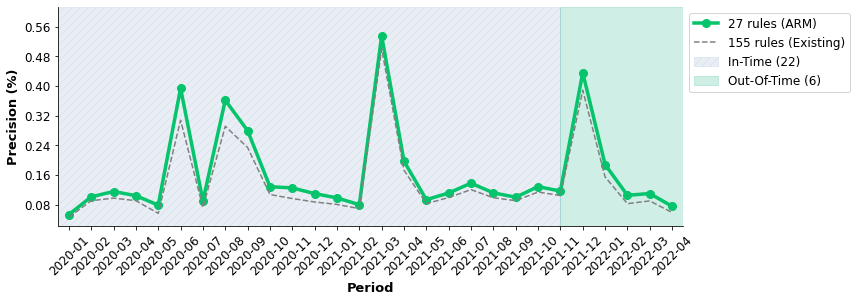

In [339]:
ax = plot_results(x, eval_asso.precision, eval_exst.precision, 
                  "Precision (%)", xticklabels, n_rules)

- Recall

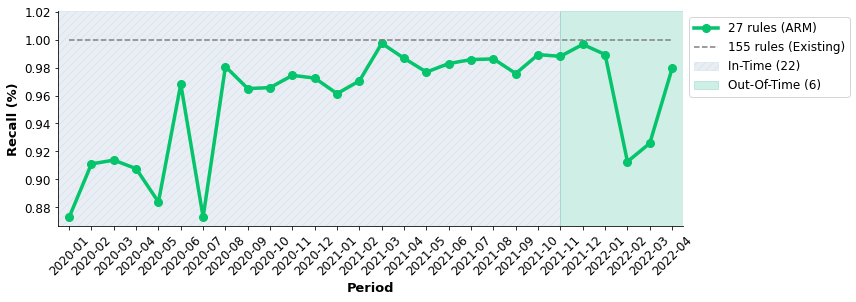

In [340]:
ax = plot_results(x, eval_asso.recall, eval_exst.recall, 
                  "Recall (%)", xticklabels, n_rules)

- Number of True-Positive transactions

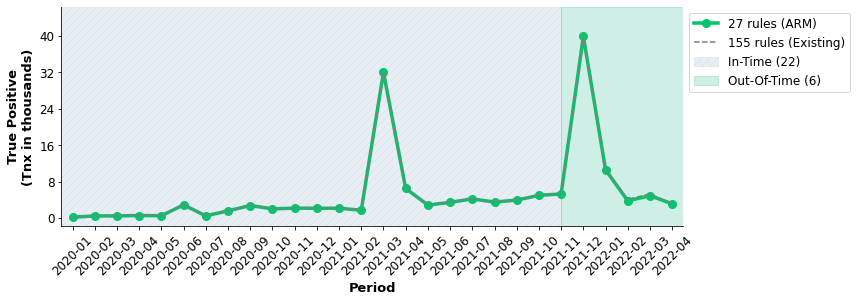

In [341]:
ax = plot_results(x, np.r_[eval_asso.tp]/1000, np.r_[eval_exst.tp]/1000, 
                  "True Positive\n(Tnx in thousands)", xticklabels, n_rules)

- Number of False-Positive transactions

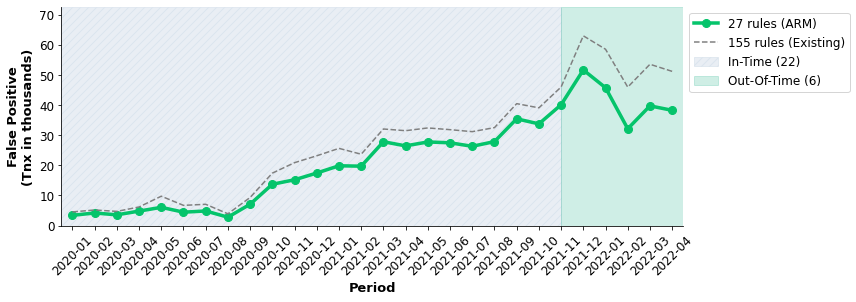

In [342]:
ax = plot_results(x, np.r_[eval_asso.fp]/1000, np.r_[eval_exst.fp]/1000, 
                  "False Positive\n(Tnx in thousands)", xticklabels, n_rules)